In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] =  "0,1"

import torch
torch.cuda.empty_cache()
print(torch.cuda.is_available())

import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

from glob import glob
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F
import time
from datetime import datetime
from torchsummary import summary

from model.unet import build_unet
#from model.fcn import build_fcn
#from model.resunet import build_resunet
#from model.segnet import SegNet
#from model.segnet3 import build_segnet
#from model.unet2plus import UNet2Plus


from dataloader import DriveDataset
from training import train, evaluate, DiceBCELoss, epoch_time, seeding, create_dir

True


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [3]:

print(torch.cuda.is_available())
model_name="unet"
#model_name="fcn"
#model_name="segnet"
#model_name="unet2p"
#model_name="resunet"
print(model_name)

True
unet


In [4]:
import albumentations as A
import cv2

transform = A.Compose([
    A.Resize(height=512,width=512),
   # A.Rotate(limit=20, p=0.5),
   # A.HorizontalFlip(p=0.5),
   # A.RandomBrightnessContrast(brightness_limit= 0.15 , contrast_limit= 0 ),
])

In [5]:
now= str(datetime.now().date())[2:].split("-") + str(datetime.now().time())[:5].split(":")
now="".join(now)
print(now)

""" Seeding """
seeding(42) #seed 고정

""" Directories """
create_dir("./weights") #모델 저장 디렉토리 생성

""" Folders """
create_dir("./results/"+model_name+'/mask/') #테스트 데이터 결과 저장 디렉토리 생성
create_dir("./results/"+model_name+'/visual/') #테스트 데이터 결과 저장 디렉토리 생성
""" Hyperparameters 설정 """
H = 512#height
W = 512 #width
size = (H, W) #image size
batch_size = 4
num_epochs = 30
lr = 1e-4
checkpoint_path = "./weights/"+ model_name +"_"+now+".pth" #모델 저장 path

train_x = sorted(glob("./Data/train/image/*"))
train_y = sorted(glob("./Data/train/gt/*"))

valid_x = sorted(glob("./Data/valid/image/*"))
valid_y = sorted(glob("./Data/valid/gt/*"))


data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)


""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y, transform)
valid_dataset = DriveDataset(valid_x, valid_y, transform)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)



if model_name == "unet":
    model = build_unet() #모델
if model_name == "fcn":
    model = build_fcn() #모델
elif model_name == "segnet":   
    model =build_segnet()
elif model_name == "unet2p":   
    model = UNet2Plus()
elif model_name == "resunet":   
    model = build_resunet()
model = model.to(device)
model = nn.DataParallel(model, device_ids=[0, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = DiceBCELoss()

2405130626
Dataset Size:
Train: 1515 - Valid: 379



[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


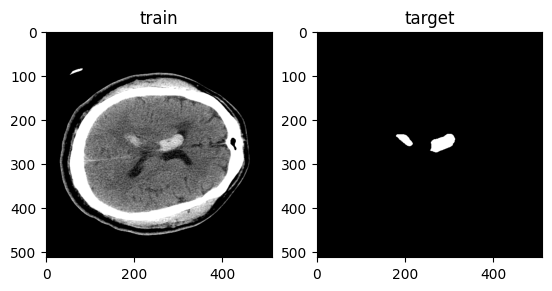

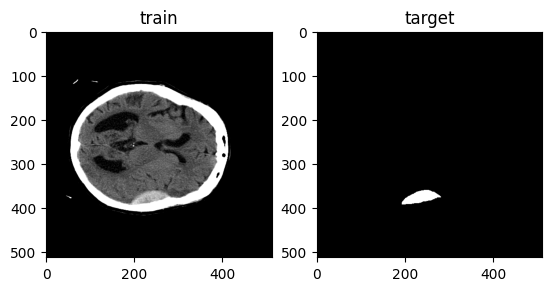

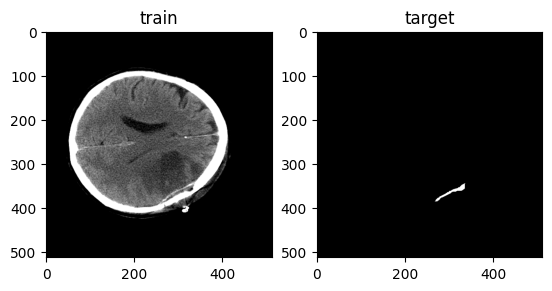

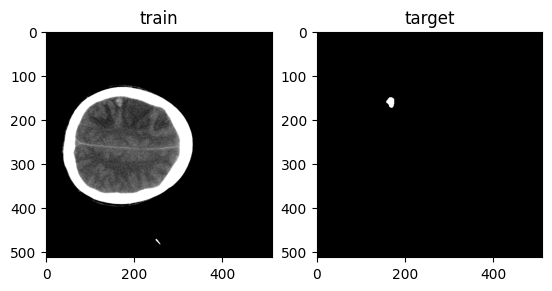

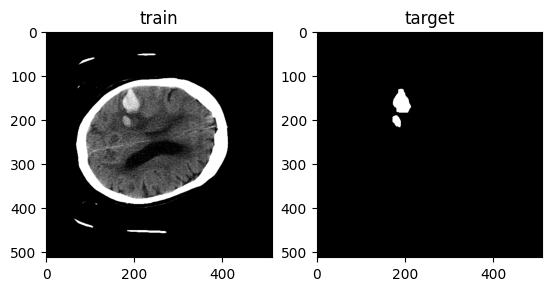

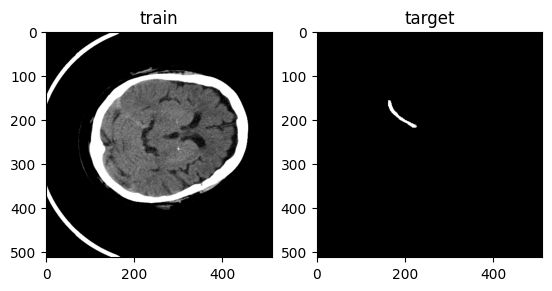

In [6]:
for j in range(3):
    image, labels = next(iter(train_loader))
    for i in range(2):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(to_pil_image(image[i]), cmap='gray')
        plt.title('train')
       # print(np.unique(image[i]))
        plt.subplot(1,2,2)
        plt.imshow(to_pil_image(labels[i]), cmap='gray')
        print(np.unique(labels[i]))
        plt.title('target')    

In [7]:

""" Training the model """
best_valid_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    """ Saving the model """
    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

Valid loss improved from inf to 1.1926. Saving checkpoint: ./weights/unet_2405130626.pth
Epoch: 01 | Epoch Time: 1m 18s
	Train Loss: 1.306
	 Val. Loss: 1.193

Valid loss improved from 1.1926 to 1.0756. Saving checkpoint: ./weights/unet_2405130626.pth
Epoch: 02 | Epoch Time: 1m 17s
	Train Loss: 1.098
	 Val. Loss: 1.076

Valid loss improved from 1.0756 to 0.9305. Saving checkpoint: ./weights/unet_2405130626.pth
Epoch: 03 | Epoch Time: 1m 17s
	Train Loss: 0.966
	 Val. Loss: 0.931

Valid loss improved from 0.9305 to 0.8123. Saving checkpoint: ./weights/unet_2405130626.pth
Epoch: 04 | Epoch Time: 1m 17s
	Train Loss: 0.839
	 Val. Loss: 0.812

Valid loss improved from 0.8123 to 0.7064. Saving checkpoint: ./weights/unet_2405130626.pth
Epoch: 05 | Epoch Time: 1m 17s
	Train Loss: 0.699
	 Val. Loss: 0.706

Epoch: 06 | Epoch Time: 1m 17s
	Train Loss: 0.566
	 Val. Loss: 1.109

Valid loss improved from 0.7064 to 0.6464. Saving checkpoint: ./weights/unet_2405130626.pth
Epoch: 07 | Epoch Time: 1m 18s


## Train

## Test

In [ ]:
from tqdm import tqdm
from operator import add
from torchvision.utils import save_image
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import torchvision
import torchvision.transforms.functional as Ff
from scipy.spatial.distance import directed_hausdorff

In [ ]:
H = 512
W = 512
size = (W, H)

In [ ]:

def calculate_metrics(y_true, y_pred):
    print(y_true.shape)
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    Y_t  = y_true.reshape(W,H)
    print(y_true.shape,Y_t.shape)
    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    Y_p  = y_pred.reshape(W,H)

    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred, zero_division=1)
    score_f1 = f1_score(y_true, y_pred, zero_division=1)
    score_recall = recall_score(y_true, y_pred, zero_division=1)
    score_precision = precision_score(y_true, y_pred, zero_division=1)
    score_acc = accuracy_score(y_true, y_pred)
    u_hausdorff = directed_hausdorff(Y_t, Y_p)[0]
    v_hausdorff = directed_hausdorff(Y_p, Y_t)[0]
    
    score_hd = max(u_hausdorff, v_hausdorff)
    return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_hd]

In [ ]:
model_name2 = model_name
#model_name2 = "unet"

checkpoint_path2 = checkpoint_path  
#checkpoint_path2 = "./weights/unet_2404221014.pth"  
print(checkpoint_path2)
""" Load dataset """
test_x = sorted(glob("./Data/test/image/*"))
test_y = sorted(glob("./Data/test/gt/*"))

""" Hyperparameters """


""" Load the checkpoint """
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if model_name2 == "unet":
    model = build_unet() #모델
if model_name2 == "fcn":
    model = build_fcn() #모델
elif model_name2 == "segnet":   
    model =build_segnet()
elif model_name2 == "unet2p":   
    model = UNet2Plus()
elif model_name2 == "resunet2p":   
    model = build_resunet_plusplus()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path2, map_location=device))
model.eval()

metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
    """ Extract the name """
    name = x.split("/")[-1].split(".")[0]

    """ Reading image """
    image = cv2.imread(x, cv2.IMREAD_GRAYSCALE) ## (512, 512)
    ori_h, ori_w = image.shape
    image = cv2.resize(image, size)
    x = np.expand_dims(image, axis=0)     ## (1, 512, 512)
    x = x/80.0
    x = np.expand_dims(x, axis=0)           ## (1, 1, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    """ Reading mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    mask = cv2.resize(mask, size)
    y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
    y = y/255.0
    y[y>=0.5]= 1
    y[y<0.5] = 0
    y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)
  
    with torch.no_grad():
        """ Prediction and Calculating FPS """
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)

        print(y.size(),'dd')
        score = calculate_metrics(y, pred_y)
        metrics_score = list(map(add, metrics_score, score))
        pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

        p = torch.Tensor(pred_y)
        save_image(p, f'./results/{model_name}/mask/{name}_pred.jpg')

jaccard = metrics_score[0]/len(test_x)
f1 = metrics_score[1]/len(test_x)
recall = metrics_score[2]/len(test_x)
precision = metrics_score[3]/len(test_x)
acc = metrics_score[4]/len(test_x)
hd = metrics_score[5]/len(test_x)
print(f"Jaccard index(IoU): {jaccard:1.4f} -  F1(Dice Coefficient):  {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - HD: {hd:1.4f}")

fps = 1/np.mean(time_taken)
print("FPS: ", fps)

In [ ]:
def show(gt, pred, gp, name):
        
        fig, axs = plt.subplots(1, 3, figsize=(10, 3))
        gt = gt.detach()
        gt = Ff.to_pil_image(gt)
        plt.axis('off')
        
        axs[0].imshow(np.asarray(gt))
        axs[0].set_title('GT')
  
        pred = pred.detach()
        pred = Ff.to_pil_image(pred)
    
        axs[1].imshow(np.asarray(pred))
        axs[1].set_title('Pred')
        fig.suptitle(name)
       
        gp = gp.detach()
        gp = Ff.to_pil_image(gp)
        axs[2].imshow(np.asarray(gp))
        axs[2].set_title((f'GT+Pred'))
        fig.suptitle(name)
                
        plt.show()
        comb_img = cv2.hconcat([np.asarray(gt), np.asarray(pred)])
        comb_img = cv2.hconcat([np.asarray(comb_img ), np.asarray(gp)])
        cv2.imwrite(f'./results/{model_name}/visual/{name}.jpg', comb_img)

In [ ]:
pred_mask = sorted(glob('./results/'+model_name2+'/visual*'))

In [ ]:
pred_mask

In [ ]:

print(model_name,checkpoint_path)
for i, x in enumerate(test_x):
    name = x.split("/")[-1].split(".")[0]
    print(name)
    img = cv2.imread(x)
    h,w = img.shape[0], img.shape[1]
    print(h,w)
    gt = cv2.imread(test_y[i], cv2.IMREAD_GRAYSCALE)
    gt = cv2.resize(gt, (w,h))
    print(gt.shape)
    pred = cv2.imread(f"./results/{model_name2}/mask/{name}_pred.jpg", cv2.IMREAD_GRAYSCALE)
    pred = cv2.resize(pred, (w,h))
    print(np.unique(pred), np.unique(gt))
    gt[gt<=100]=0
    gt[gt>100]=1
    pred[pred<=100]=0
    pred[pred>100]=1
    
    img = torch.from_numpy(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).permute(2,0,1)
    gt = torch.from_numpy(gt)
    pred = torch.from_numpy(pred)
    gt[gt<=0] = False
    gt[gt>0] = True
    pred[pred<=0] = False
    pred[pred>0] = True    
    gt = torch.tensor(gt, dtype=bool)
    pred = torch.tensor(pred, dtype=bool)
    img_gt = torchvision.utils.draw_segmentation_masks(img, gt, alpha=0.3, colors=(0,255,0))
    img_pred  = torchvision.utils.draw_segmentation_masks(img, pred, alpha=0.3, colors=(0,0,255))
    img_gt_pred = torchvision.utils.draw_segmentation_masks(img_gt, pred, alpha=0.3, colors=(0,0,255))
   # gt = gt.detach()
   # gt = Ff.to_pil_image(gt)
    #
   # plt.imshow(comb_img)
    show(img_gt, img_pred,img_gt_pred, name)

In [ ]:
img.shape